In [34]:
# Imports
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.models import MobileNet_V2_Weights

import matplotlib.pyplot as plt
import pandas as pd
import torch.optim as optim
from tqdm.notebook import tqdm
import tempfile
import shutil
import random
from sklearn.model_selection import KFold

mount drive if running in google colab


In [35]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print("In Colab: {}".format(IN_COLAB))

if IN_COLAB:
    from image_utils import get_sample_image_size
    from csv_utils import split_classes, how_many, split_classes_threshold
    from file_utils import train_test_split, num_images
    from google.colab import drive
    drive.mount('/content/gdrive')

else:
    import sys
    sys.path.append("..")
    from src.utils.image_utils import get_sample_image_size
    from src.utils.csv_utils import split_classes, how_many, split_classes_threshold
    from src.utils.file_utils import train_test_split, num_images

In Colab: False


set computation device to gpu if available


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Computation device: {device}")

Computation device: cpu


set seed for reproducibility


In [37]:
torch.manual_seed(0)
random.seed(0)

set hyper parameters


In [38]:
EPOCHS = 10
BATCH = 64
FOLDS = 5

# percent of all data to go towards testing and validation
# TRACKS_PER_CLASS = 500
PERCENT_TESTING = 0.15
PERCENT_VALIDATION = 0.15
LEARNING_RATE = 0.001

# spectrogram parameters
RESOLUTION = "low"
TRACK_DURATION = 15

# popularity thresholds
TRACKS_PER_CLASS = 1000
HIGH_THRESHOLD = 500000
LOW_THRESHOLD = 500000

#### load the train and test data


In [39]:
# Setting paths
base_path = f"../data" if not IN_COLAB else f"/content/gdrive/MyDrive/AI-Project/data"
dir_name = f"ch_{RESOLUTION}_{TRACK_DURATION}_all"
spectrograms_path = f"{base_path}/spectrograms/{dir_name}"
csv_path = f"{base_path}/audio_features.csv"
df = pd.read_csv(csv_path)

print(f"Csv Length: {len(df)}")
print(f"Number of spectrograms: {num_images(spectrograms_path)}")

num_viral = how_many(
    csv_path, 'number_of_videos', HIGH_THRESHOLD, 'above')
num_not_viral = how_many(
    csv_path, 'number_of_videos', LOW_THRESHOLD, 'below')

print(f"Number of tracks above threshold: {num_viral}")
print(f"Number of tracks below threshold: {num_not_viral}")

Csv Length: 3932
Number of spectrograms: 3914
Number of tracks above threshold: 1416
Number of tracks below threshold: 2516


All images should be the same size but we resize them according to the first image just to be safe.


In [40]:
image_size = get_sample_image_size(spectrograms_path)
HEIGHT, WIDTH = image_size[0], image_size[1]
print(f"height: {image_size[0]}, width: {image_size[1]}")

Number of channels in the image: 1
height: 128, width: 162


In [41]:
transform = transforms.Compose(
    [
        transforms.Resize((HEIGHT, WIDTH)),
        # transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)


def get_datasets():

    # create temporary folder to store spectrograms
    root_dir = "../data/temp" if not IN_COLAB else './temp'
    os.makedirs(root_dir, exist_ok=True)
    temp_dir = tempfile.mkdtemp(dir=root_dir)

    # split into two classes based on popularity thresholds
    out_path = f"{temp_dir}/"
    # split_classes(
    #     csv_path, spectrograms_path, out_path, ["viral", "notviral"], TRACKS_PER_CLASS
    # )
    split_classes_threshold(csv_path, spectrograms_path, out_path, [
                            "viral", "notviral"], HIGH_THRESHOLD, LOW_THRESHOLD)

    # copy spectrograms to temporary folder split into train and test directories
    data_dir = tempfile.mkdtemp(prefix=dir_name + '_', dir=root_dir)
    print(f"Data directory: {data_dir}")
    train_dir, test_dir = train_test_split(temp_dir, data_dir, PERCENT_TESTING)
    train_dataset = ImageFolder(train_dir, transform=transform)
    test_dataset = ImageFolder(test_dir, transform=transform)

    # delete temporary folder
    shutil.rmtree(temp_dir)
    return train_dataset, test_dataset, data_dir

In [42]:
train_dataset, test_dataset, data_dir = get_datasets()

print(f"number of training images: {len(train_dataset)}")
print(f"number of testing images: {len(test_dataset)}")

popularity: 33542864, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 6200000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 4700000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 1700000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 1100000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 9600000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 11242864, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 1300000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 8000000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 4500000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 4166632, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 4300000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 2357148, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 5500000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 5400000, class_path: ../data/temp/tmpw0xu3a42/viral
popularity: 3500000, class_path: ../da

#### Looking at the dataset


In [43]:
img, label = train_dataset[0]
print(img.shape, label)
print("classes : \n", train_dataset.classes)

# num images per class
print("num images per class")
print(train_dataset.targets.count(0))
print(train_dataset.targets.count(1))

torch.Size([3, 128, 162]) 0
classes : 
 ['notviral', 'viral']
num images per class
2129
1199


display the first image in the dataset


Label : notviral


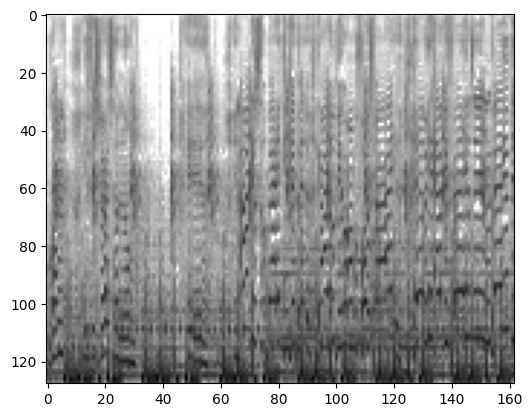

In [44]:
def display_img(img, label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))


display_img(*train_dataset[0])

load the train and validation into batches.


In [45]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

val_size = int(len(train_dataset) * PERCENT_VALIDATION)
train_size = len(train_dataset) - val_size

train_data, val_data = random_split(train_dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

# train_dl = DataLoader(train_data, BATCH, shuffle = True, num_workers = 4, pin_memory = True)
# val_dl = DataLoader(val_data, BATCH*2, num_workers = 4, pin_memory = True)

train_dl = DataLoader(train_data, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_data, batch_size=BATCH)
test_dl = DataLoader(test_dataset, batch_size=BATCH)

Length of Train Data : 2829
Length of Validation Data : 499


visualize a single batch of images


In [46]:
from torchvision.utils import make_grid


def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break


# show_batch(train_dl)

Initialize model:


In [47]:
# list all models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [48]:
# model = VGG11(in_channels=1, num_classes=2).to(device)

# load the model
model = models.mobilenet_v2(weights = MobileNet_V2_Weights.DEFAULT).to(device)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

trying pretrained models

Function for training (one epoch)


In [30]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    cum_loss = 0.0
    cum_correct = 0

    for x, y in tqdm(trainloader, total=len(trainloader), desc="Training"):
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)

        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cum_loss += loss.item()
        cum_correct += (pred.argmax(1) == y).sum().item()

    epoch_acc = cum_correct / len(trainloader.dataset)
    epoch_loss = cum_loss / len(trainloader)
    return epoch_acc, epoch_loss

Function for testing (one epoch)


In [31]:
def test(model, testloader, criterion):
    model.eval()
    cum_loss = 0.0
    cum_correct = 0

    with torch.no_grad():
        for x, y in tqdm(testloader, total=len(testloader), desc="Testing"):
            (x, y) = (x.to(device), y.to(device))
            pred = model(x)

            loss = criterion(pred, y)
            cum_loss += loss
            cum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    epoch_acc = cum_correct / len(testloader.dataset)
    epoch_loss = cum_loss / len(testloader)
    return epoch_acc, epoch_loss

Training and testing the model:


In [50]:
# dictionary to keep track of losses and accuracies
H = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

# train the model
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_acc, train_epoch_loss = train(model, train_dl, optimizer, criterion)
    test_epoch_acc, test_epoch_loss = test(model, test_dl, criterion)
    # print all the metrics
    print(f"Train loss: {train_epoch_loss:.4f} | Train acc: {train_epoch_acc:.4f}")
    print(f"Test loss: {test_epoch_loss:.4f} | Test acc: {test_epoch_acc:.4f}")
    H["train_loss"].append(train_epoch_loss)
    H["train_acc"].append(train_epoch_acc)
    H["test_loss"].append(test_epoch_loss)
    H["test_acc"].append(test_epoch_acc)

Epoch 1 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 3.9855 | Train acc: 0.3747
Test loss: 3.7090 | Test acc: 0.4386
Epoch 2 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 3.1884 | Train acc: 0.5323
Test loss: 2.9520 | Test acc: 0.5375
Epoch 3 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 2.5577 | Train acc: 0.6027
Test loss: 2.7879 | Test acc: 0.5666
Epoch 4 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 2.1351 | Train acc: 0.6264
Test loss: 2.0131 | Test acc: 0.6058
Epoch 5 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.7714 | Train acc: 0.6334
Test loss: 2.0051 | Test acc: 0.6177
Epoch 6 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.5091 | Train acc: 0.6440
Test loss: 1.7151 | Test acc: 0.6058
Epoch 7 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.3167 | Train acc: 0.6539
Test loss: 1.4685 | Test acc: 0.6246
Epoch 8 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.1558 | Train acc: 0.6557
Test loss: 1.4980 | Test acc: 0.6314
Epoch 9 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.0531 | Train acc: 0.6525
Test loss: 1.1819 | Test acc: 0.5341
Epoch 10 of 10


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.9476 | Train acc: 0.6727
Test loss: 1.1172 | Test acc: 0.5734


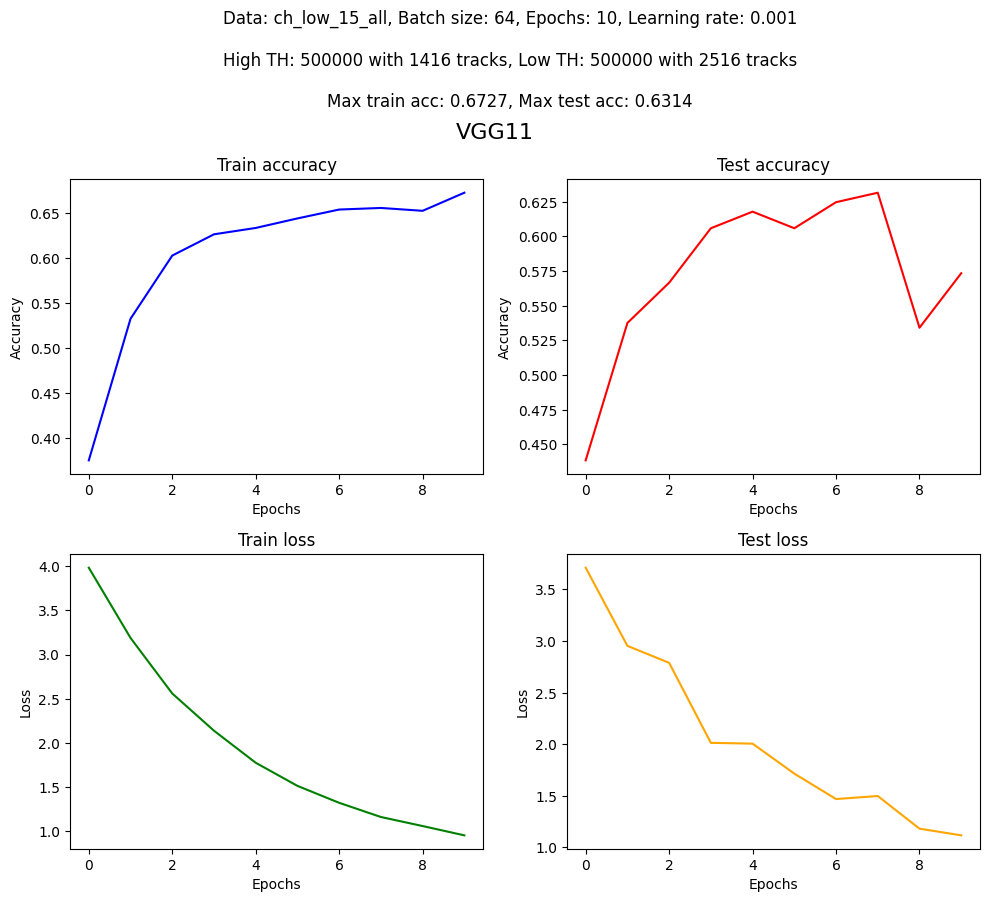

In [51]:
max_train_acc = max(H["train_acc"])
max_test_acc = max(H["test_acc"])

fig = plt.figure(figsize=(10, 8))
# supertitle
fig.suptitle("VGG11", fontsize=16)
info = f"""Data: {dir_name}, Batch size: {BATCH}, Epochs: {EPOCHS}, Learning rate: {LEARNING_RATE}\n
High TH: {HIGH_THRESHOLD} with {num_viral} tracks, Low TH: {LOW_THRESHOLD} with {num_not_viral} tracks\n
Max train acc: {max_train_acc:.4f}, Max test acc: {max_test_acc:.4f}"""
fig.text(0.515, 1, info, ha="center", fontsize=12)


sub1 = fig.add_subplot(221)
sub1.set_title("Train accuracy")
sub1.plot(H["train_acc"], color="blue", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub2 = fig.add_subplot(222)
sub2.set_title("Test accuracy")
sub2.plot(H["test_acc"], color="red", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

sub3 = fig.add_subplot(223)
sub3.set_title("Train loss")
sub3.plot(H["train_loss"], color="green", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")


sub4 = fig.add_subplot(224)
sub4.set_title("Test loss")
sub4.plot([l.item() for l in H["test_loss"]], color="orange", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()